# 6.3 Edmonton AC Loads: Multi-Scenario Analysis

In [ ]:
import xarray as xr
from xclim import sdba
from xclim.core.calendar import convert_calendar
import xclim.indices as xci
import xclim.ensembles as xce
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import ec3
import gcsfs
import zarr

# lat and lon coordinates for Edmonton
lat_edm = 53.5
lon_edm = -113.5

# time periods for historical and future periods
years_hist = range(1980, 2011) # remember that range(start, end) is not inclusive of `end`
years_future = range(2070, 2101)

# url for the CSV file that contains the data catalog
url_gcsfs_catalog = 'https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv'

In [ ]:
# get the same station data as from 6.1 and 6.2

def download_station_data(stn_id, years = range(1992, 2022)):
    """
    Download ECCC observational data at the weather station identified with stn_id,
    re-name the columns to more useful names. Optional: select specific years of data,
    but by default, download all data from 1990--2020.
    """
    # download the data
    df = ec3.get_data(stn_id, years = years, progress = False)
    
    # dictionary mapping original column names to new ones
    column_name_dict = {'Date/Time': 'time', 
                        'Mean Temp (°C)': 'tas',
                        'Latitude (y)': 'lat',
                        'Longitude (x)': 'lon',
                        'Station Name': 'Name'}
    
    df = df.rename(columns = column_name_dict)
    
    # select only the variables we re-named - you can comment this out if you want to keep all variables
    df = df[list(column_name_dict.values())]
    
    # set the "time" column as an index column and convert it from strings to Datetime objects to make
    # selecting times easier
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index("time")
    
    # sort the data in proper chronological order
    df = df.sort_index()
    
    df = df.dropna()
    
    return df

In [ ]:
# download the station data
stn_id_list = [1867, 31427]
df_list = []
for stn_id in stn_id_list:
    df = download_station_data(stn_id, years = years_hist)
    df_list.append(df)
    
stn_df = pd.concat(df_list, axis = 0)

# now convert it to xarray format for easier use with the model data and xclim

# drop lat and lon variables, since we want these to be coordinates in the xr.Dataset
stn_lon = stn_df.lon.values[0] + 360 # convert lon to same convention as model data
stn_lat = stn_df.lat.values[0] 

stn_df = stn_df.drop(['lat', 'lon'], axis = 1)

stn_ds = xr.Dataset.from_dataframe(stn_df)
stn_ds = stn_ds.assign_coords(lat = stn_lat, lon = stn_lon)

stn_ds_noleap = convert_calendar(stn_ds, 'noleap')
tas_obs_noleap = stn_ds_noleap.tas

## 6.3.1 Creating a Multi-Model, Multi-Scenario Ensemble

Now we'll search the catalog for data from the same models as in 6.2, but for multiple SSP scenarios. We'll use the 4 most common SSPs, listed in increasing order of end-of-century radiative forcing:
* SSP1-2.6 (Sustainability)
* SSP2-4.5 (Middle of the Road)
* SSP3-7.0 (Regionaly Rivalry)
* SSP5-8.5 (Fossil-Fueled Development)

For each model, we'll again use only a single ensemble member. The code below will search the Google Cloud CMIP6 data catalog for ensemble members that include the historical simulation, plus branches for each of the 4 SSPs listed above. For consistency between the historical data and future projections, they must all come from the same ensemble member. 

In [4]:
# open the Google Cloud model data catalog with pandas
df_catalog = pd.read_csv(url_gcsfs_catalog)

# search for entries which have daily tas data from the selected scenarios and models
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

models = ['AWI-CM-1-1-MR', 'CESM2', 'CanESM5', 'EC-Earth3', 
          'FGOALS-g3','INM-CM5-0', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0']

search_string_mm = "table_id == 'day' & variable_id == 'tas'"
search_string_mm += f" & experiment_id == {scenarios}"
search_string_mm += f"& source_id == {models}"
df_search_mm = df_catalog.query(search_string_mm)

# for each model, select only one ensemble member
df_search_mm = df_search_mm.sort_values('member_id')
df_search_mm_onemember = df_search_mm.drop_duplicates(['source_id', 'experiment_id'], keep = 'first')
df_search_mm_onemember = df_search_mm_onemember.sort_values('source_id')
df_search_mm_onemember

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
203819,ScenarioMIP,AWI,AWI-CM-1-1-MR,ssp126,r1i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR...,NaN,20190529
203678,ScenarioMIP,AWI,AWI-CM-1-1-MR,ssp245,r1i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR...,NaN,20190529
204072,ScenarioMIP,AWI,AWI-CM-1-1-MR,ssp585,r1i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR...,NaN,20190529
203852,ScenarioMIP,AWI,AWI-CM-1-1-MR,ssp370,r1i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR...,NaN,20190529
45210,CMIP,AWI,AWI-CM-1-1-MR,historical,r1i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/histor...,NaN,20181218
444869,ScenarioMIP,NCAR,CESM2,ssp585,r10i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585...,NaN,20200528
445750,ScenarioMIP,NCAR,CESM2,ssp245,r10i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp245...,NaN,20200528
66385,CMIP,NCAR,CESM2,historical,r10i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190313
445868,ScenarioMIP,NCAR,CESM2,ssp370,r10i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp370...,NaN,20200528
444314,ScenarioMIP,NCAR,CESM2,ssp126,r10i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp126...,NaN,20200528


In [5]:
# ideally we'd use only one historical ensemble member for each model, and have all the SSP scenarios
# for that model branch from the same historical simulation. This has worked out for most of the models,
# but not IPSL or INM. Let's see if we can find a single member which works for those models

for model in ['IPSL-CM6A-LR', 'INM-CM5-0']:
    print(model)
    # drop the original results for this model from the search results
    where_current_model = df_search_mm_onemember[df_search_mm_onemember.source_id == model].index
    df_search_mm_onemember = df_search_mm_onemember.drop(where_current_model)
    
    search_model = f"source_id == '{model}' & table_id == 'day' & variable_id == 'tas' & experiment_id == {scenarios}"
    df_search_model = df_catalog.query(search_model)
    df_search_model = df_search_model.sort_values('member_id')
    exps_per_member = df_search_model.groupby('member_id').size()
    
    # search for ensemble members that have the same number of entries as there are scenarios in our list
    candidate_members = exps_per_member.loc[exps_per_member == len(scenarios)].index.sort_values()

    # take the first one, if there are any results, and append its entries to the search results
    if len(candidate_members) > 0:
        member = candidate_members[0]
        results_for_this_model = df_search_model[df_search_model.member_id == member]
        df_search_mm_onemember = df_search_mm_onemember.append(results_for_this_model)
        
df_search_mm_onemember[df_search_mm_onemember.source_id.isin(['IPSL-CM6A-LR', 'INM-CM5-0'])]

IPSL-CM6A-LR
INM-CM5-0


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
389939,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp370,r14i1p1f1,day,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20191122
388751,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp245,r14i1p1f1,day,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20191121
388475,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp585,r14i1p1f1,day,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20191121
206789,CMIP,IPSL,IPSL-CM6A-LR,historical,r14i1p1f1,day,tas,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20190614
386693,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp126,r14i1p1f1,day,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20191121
206447,CMIP,INM,INM-CM5-0,historical,r1i1p1f1,day,tas,gr1,gs://cmip6/CMIP6/CMIP/INM/INM-CM5-0/historical...,NaN,20190610
209182,ScenarioMIP,INM,INM-CM5-0,ssp245,r1i1p1f1,day,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/INM/INM-CM5-0/ssp...,NaN,20190619
244566,ScenarioMIP,INM,INM-CM5-0,ssp585,r1i1p1f1,day,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/INM/INM-CM5-0/ssp...,NaN,20190724
208890,ScenarioMIP,INM,INM-CM5-0,ssp370,r1i1p1f1,day,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/INM/INM-CM5-0/ssp...,NaN,20190618
209140,ScenarioMIP,INM,INM-CM5-0,ssp126,r1i1p1f1,day,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/INM/INM-CM5-0/ssp...,NaN,20190619


Having found entries that suit our needs, let's download the data and format it using `xclim.ensembles`.

In [6]:
# function for pre-processing data
def get_and_process_data(catalog_df, model, scenario, gcs, lat, lon, years):
    # get the ztore url for this model and scenario
    df_scen = catalog_df.query(f"source_id == '{model}' & experiment_id == '{scenario}'")
    zstore_url = df_scen.zstore.values[0]
    
    # get the GCS mapper from the url
    mapper = gcs.get_mapper(zstore_url)
    
    # open the file with xarray
    ds = xr.open_zarr(mapper, consolidated = True)
    
    # get the tas data, select the time period, and interp to the desired location
    tas_loc = ds.tas.sel(time = ds.time.dt.year.isin(years)).interp(lat = lat, lon = lon)
    
    # drop 'height' coordinate, which is always 2m but isn't present on all datasets
    if 'height' in tas_loc.coords.keys():
        tas_loc = tas_loc.reset_coords('height', drop = True)
        
    # some datasets put the date at 12:00 whereas some put it at 00:00. To make all
    # of them consistent, simply change the time coordinate to the date only
    tas_loc = tas_loc.assign_coords(time = tas_loc.time.dt.floor('D'))
    # convert from Kelvin to Celsius and return
    
    tas_loc = tas_loc - 273.15
    return tas_loc.compute()

In [7]:
# authenticate access to Google Cloud
gcs = gcsfs.GCSFileSystem(token='anon')

# use the function to download the data, this may take a few minutes to run
ds_list_hist = []
ds_list_future = []
for model in models:
    print(f"========================{model}=============================")
    print('historical')
    tas_model_hist = get_and_process_data(df_search_mm_onemember, model, 'historical', 
                                          gcs, stn_lat, stn_lon, years_hist)
    ds_list_hist.append(tas_model_hist)
    
    # get the future simulation data for this model, for each scenario
    ds_list_scen = []
    for scenario in scenarios[1:]: # exclude 'historical' from this iteration
        print(scenario)
        tas_model_future = get_and_process_data(df_search_mm_onemember, model, scenario, 
                                                gcs, stn_lat, stn_lon, years_future)
        ds_list_scen.append(tas_model_future)
    
    # create ensemble for this one model, where the 'realization' dim represents the different scenarios
    ds_future = xce.create_ensemble(ds_list_scen, realizations = scenarios[1:])
    
    # rename the 'realization' dim
    ds_future = ds_future.rename({'realization': 'scenario'})
    ds_list_future.append(ds_future)

print('finished acquiring model data')
    
    

========================AWI-CM-1-1-MR=============================
historical
ssp126
ssp245
ssp370
ssp585
========================CESM2=============================
historical
ssp126
ssp245
ssp370
ssp585
========================CanESM5=============================
historical
ssp126
ssp245
ssp370
ssp585
========================EC-Earth3=============================
historical
ssp126
ssp245
ssp370
ssp585
========================FGOALS-g3=============================
historical
ssp126
ssp245
ssp370
ssp585
========================INM-CM5-0=============================
historical
ssp126
ssp245
ssp370
ssp585
========================IPSL-CM6A-LR=============================
historical
ssp126
ssp245
ssp370
ssp585
========================MPI-ESM1-2-LR=============================
historical
ssp126
ssp245
ssp370
ssp585
========================MRI-ESM2-0=============================
historical
ssp126


/Users/mikemorris/opt/anaconda3/envs/UTCDW/lib/python3.9/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/mikemorris/opt/anaconda3/envs/UTCDW/lib/python3.9/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/mikemorris/opt/anaconda3/envs/UTCDW/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


ssp245
ssp370
ssp585


/Users/mikemorris/opt/anaconda3/envs/UTCDW/lib/python3.9/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/mikemorris/opt/anaconda3/envs/UTCDW/lib/python3.9/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/mikemorris/opt/anaconda3/envs/UTCDW/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


finished acquiring model data


In [11]:
# concatenate the ds_lists together
ds_ens_hist_raw = xce.create_ensemble(ds_list_hist,                             
                                      realizations = models,
                                      calendar = 'noleap')

ds_ens_future_raw = xce.create_ensemble(ds_list_future, 
                                      realizations = models,
                                      calendar = 'noleap')

# rename 'realization' dimension to 'model'
ds_ens_hist_raw = ds_ens_hist_raw.rename({'realization': 'model'})
ds_ens_future_raw = ds_ens_future_raw.rename({'realization': 'model'})

In [71]:
# write the data to output files to save time later when re-running this notebook
ds_ens_hist_raw.to_netcdf('data_files/tas.cmip6.daily.historical.1980-2010.edmonton.nc')
ds_ens_future_raw.to_netcdf('data_files/tas.cmip6.daily.ssp1235.2070-2100.edmonton.nc')

## 6.3.2 Exploratory Analysis

With this multi-model, multi-scenario ensemble, we can do much of the same analysis as before, and also quantify the effects of scenario uncertainty on the future projections. Since the historical validation for this case would be exactly the same as Section 6.2 (since there's only one historical scenario), we can get right into looking at the raw model future projections. Since we already explored model uncertainty in 6.2, let's look at the raw projections of the multi-model ensemble. Remember though that when we get to the bias-correction, it should be applied to each model individually, **not to the multi-model mean**.

In [16]:
# calculate the daily climatology, averaged across models, for the historical and future data
tas_ens_hist_raw = ds_ens_hist_raw.tas
tas_ens_future_raw = ds_ens_future_raw.tas

tas_ensmean_hist_raw_clim = tas_ens_hist_raw.groupby('time.dayofyear').mean(('time', 'model')).compute()
tas_ensmean_future_raw_clim = tas_ens_future_raw.groupby('time.dayofyear').mean(('time', 'model')).compute()

# daily climatology for obs
tas_dailyclim_obs = tas_obs_noleap.groupby('time.dayofyear').mean('time').compute()
tas_dailyclim_std_obs = tas_obs_noleap.groupby('time.dayofyear').std('time').compute()

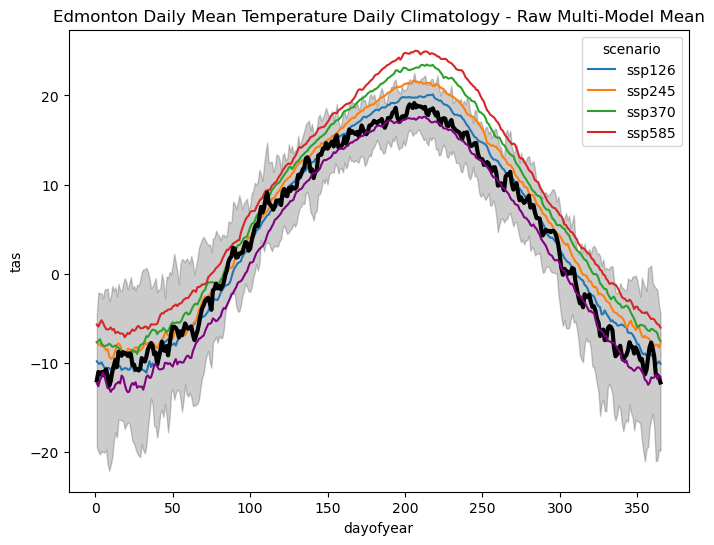

In [47]:
# plot the daily climatologies
fig, ax = plt.subplots(figsize = (8,6))

# daily climatologies as 1D curves
# future multi-model means
tas_ensmean_future_raw_clim.plot.line(ax = ax, hue = 'scenario')

# obs
tas_dailyclim_obs.plot.line(ax = ax, label = "Station Obs", color = 'k', linewidth = 3)

# models
# historical multi-model mean
tas_ensmean_hist_raw_clim.plot.line(color = 'purple', label = "Historical Multi-Model Mean")


# 1 sigma shading
# obs
ax.fill_between(tas_dailyclim_obs.dayofyear,
                tas_dailyclim_obs - tas_dailyclim_std_obs, 
                tas_dailyclim_obs + tas_dailyclim_std_obs,
                alpha = 0.2, color = 'k')

ax.set_title("Edmonton Daily Mean Temperature Daily Climatology - Raw Multi-Model Mean")
plt.show()

This plot shows how the multi-model average daily mean temperature climatology varies with the future scenario. The historical climatology (purple) shows a slight cold bias relative to the observations (black), which will hopefully be eliminated after bias-correcting the models. The future scenarios all show warming realtive to the historical period, though only the two highest-emission scenarios (SSP3-7.0 and SSP5-8.5) have peaks that exceed the observed range of variability.

We should expect that CDDs will increase under each scenario, and the increases will probably be largest for the higher forcing scenarios. However, we already saw that the inter-model spread for projections was quite large for the single-scenario analysis. Will the spread across scenarios be larger? Let's calculate the CDDs before and after bias-adjustment and investigate.

In [49]:
# assign unit to temperature data
tas_ens_hist_raw.attrs['units'] = 'degC'
tas_ens_future_raw.attrs['units'] = 'degC'
tas_obs_noleap.attrs['units'] = 'degC'

# calculate CDDs
cdd_obs =  xci.cooling_degree_days(tas_obs_noleap).compute()
cdds_mm_hist_raw = xci.cooling_degree_days(tas_ens_hist_raw).compute()
cdds_mm_future_raw = xci.cooling_degree_days(tas_ens_future_raw).compute()

# long-term means 
cdd_obs_ltm = cdd_obs.mean('time')
cdds_mm_hist_raw_ltm = cdds_mm_hist_raw.mean('time')
cdds_mm_future_raw_ltm = cdds_mm_future_raw.mean('time')

# climate change delta
cdds_mm_delta_raw = cdds_mm_future_raw_ltm - cdds_mm_hist_raw_ltm 

# multi-model mean change
cdds_mm_delta_raw_ensmean = cdds_mm_delta_raw.mean('model')

# represent model spread for each scenario by taking stdev across models for the change in long-term means
cdds_mm_delta_raw_model_spread = cdds_mm_delta_raw.std('model')



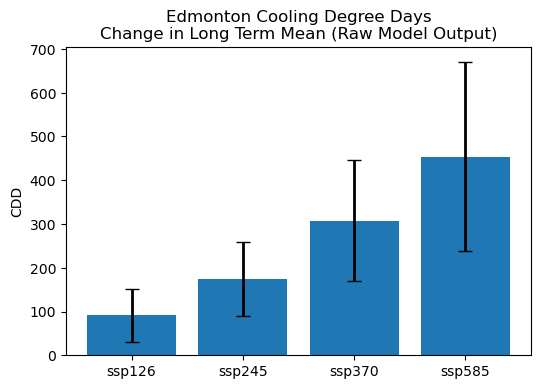

In [57]:
# plot changes to CDDs from the raw model output
fig, ax = plt.subplots( figsize = (6, 4))
ax.set_title("Edmonton Cooling Degree Days\nChange in Long Term Mean (Raw Model Output)")

# plot long-term means
bars = ax.bar(scenarios[1:], cdds_mm_delta_raw_ensmean.values, 
             yerr = cdds_mm_delta_raw_model_spread.values, 
             capsize = 5, error_kw = {'ecolor': 'k', 'elinewidth': 2})

ax.set_ylabel('CDD')

plt.show()

In this plot the blue bars show the multi-model mean change in the average annual CDDs, while the black errorbars represent the standard deviation across models for the given scenario. Clearly scenario uncertainty plays a large role in the overall range of projections, with the low end of the SSP5-8.5 projections not overlapping at all with the high end of the SSP2-1.6 projections.

Interestingly, the model spread is larger for the higher forcing scenarios - in other words the model uncertainty grows with the strength of the forcing. Is that also true for the *percent uncertainty*? Let's check:

In [70]:
cdds_mm_delta_raw_model_spread_pct = (cdds_mm_delta_raw_model_spread / cdds_mm_delta_raw_ensmean) * 100
cdds_mm_delta_raw_model_spread_pct = cdds_mm_delta_raw_model_spread_pct.rename('pct_model_spread_raw')
cdds_mm_delta_raw_model_spread_pct.to_dataframe() # this will print out the results in a nice table

,lat,lon,pct_model_spread_raw
scenario,,,
ssp126,53.57,246.48,65.779602
ssp245,53.57,246.48,48.669932
ssp370,53.57,246.48,45.039126
ssp585,53.57,246.48,47.636290


The above table shows that the percent uncertainty isn't really larger for the higher forcing scenarios. In fact, the scenario with the largest relative model spread is the lowest forcing scenario. Proportionally, model uncertainty is just under 50% for the three non-net-zero scenarios. We'll re-do this calculation for the bias-adjusted CDD projections to get a final assessment of the magnitude of model uncertainty on the projections, which can then be compared to the magnitude of the spread across scenarios.

## 6.3.3 Applying Bias-Correction

Now it's time to apply the QDM bias correction to the model `tas` data.